In [224]:
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint

import re
from bs4 import BeautifulSoup
#nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from tqdm import tqdm
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [122]:
df = pd.read_csv("merged.csv")

In [124]:
df.dropna(subset=['file'],inplace = True)

In [29]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

def lemmatize_words(words):

    lemmatized_words = [WordNetLemmatizer().lemmatize(word, 'v') for word in words]
    
    return lemmatized_words


def lemmatize_words_v2(sentence):
    
    lemmatizer = WordNetLemmatizer() 
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence)) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))


    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
                # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:       
                # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
                
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence


word_pattern = re.compile('\w+')

In [130]:
#df2["final"] = df2['file'].apply(lambda x:lemmatize_words_v2(x))

In [126]:
with open('H4N-inf.txt') as f:
    lines = f.read().splitlines()

    wrds_h4 = [i.lower() for i in lines]


with open('Fin_Neg.txt') as f:
    lines_fin = f.read().splitlines()

    wrds_fin = [i.lower() for i in lines_fin]

In [110]:
def get_bag_of_words(sentiment_words, docs):

    vec = CountVectorizer(vocabulary=sentiment_words)
    vectors = vec.fit_transform(docs)
    words_list = vec.get_feature_names()
    bag_of_words = np.zeros([len(docs), len(words_list)])
    
    for i in range(len(docs)):
        bag_of_words[i] = vectors[i].toarray()[0]
    return bag_of_words.astype(int)

def get_tfidf(sentiment_words, docs):
    
    vec = TfidfVectorizer(vocabulary=sentiment_words)
    tfidf = vec.fit_transform(docs)
    
    return tfidf.toarray()

In [128]:
df["count_h4"] = np.sum(get_bag_of_words(wrds_h4,df["file"]),axis = 1)

In [132]:
df["count_fin"] = np.sum(get_bag_of_words(wrds_fin,df["file"]),axis = 1)

In [133]:
df['len'] = df['file'].apply(lambda x: len(x))

In [136]:
df['ratio_h4'] = df['count_h4']/df['len']
df['ratio_fin'] = df['count_fin']/df['len']

In [139]:
df['tfidf_h4'] = np.sum(get_tfidf(wrds_h4,df["file"]),axis = 1)

In [140]:
df['tfidf_neg'] = np.sum(get_tfidf(wrds_fin,df["file"]),axis = 1)

In [189]:
df_out = df[['ticker','date','3_day_buy_and_hold_excess_return','3_day_buy_and_hold_excess_log_return','ratio_h4',\
            'ratio_fin','tfidf_h4','tfidf_neg']]
df_out.rename(columns={"3_day_buy_and_hold_excess_return": "return"},inplace=True)


/Users/akshat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


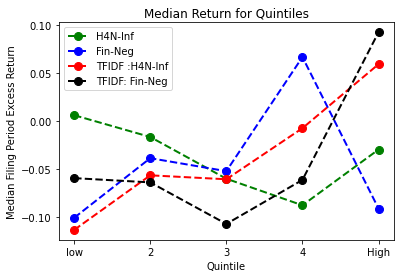

In [219]:
columns = ['ratio_h4','ratio_fin','tfidf_h4','tfidf_neg']
Quintile = ['low', '2', '3', '4','High']
for i in range(len(columns)):
#col = 'ratio_h4'
    col = columns[i]
    q = df_out.quantile([0.00, 0.2, 0.40, 0.6,0.8, 1.00])

    q1 = ((df_out[col]>=q[col][0.00]) & (df_out[col]<q[col][0.20]))
    q2 = ((df_out[col]>=q[col][0.20]) & (df_out[col]<q[col][0.40]))
    q3 = ((df_out[col]>=q[col][0.40]) & (df_out[col]<q[col][0.60]))
    q4 = ((df_out[col]>=q[col][0.60]) & (df_out[col]<q[col][0.80]))
    q5 = ((df_out[col]>=q[col][0.80]) & (df_out[col]<=q[col][1.00]))


    Median_Return[i] = [df_out[['return']][q1].median()[0]*100, df_out[['return']][q2].median()[0]*100, \
       df_out[['return']][q3].median()[0]*100, df_out[['return']][q4].median()[0]*100,df_out[['return']][q5].median()[0]*100]
  
    
    
plt.plot(Quintile,Median_Return[0],color='green', marker='o', linestyle='dashed',linewidth=2, markersize=8,label ="H4N-Inf")
plt.plot(Quintile,Median_Return[1],color='blue', marker='o',linestyle='dashed',linewidth=2, markersize=8,label ="Fin-Neg")
plt.plot(Quintile,Median_Return[2],color='red', marker='o', linestyle='dashed',linewidth=2, markersize=8,label ="TFIDF :H4N-Inf")
plt.plot(Quintile,Median_Return[3],color='black', marker='o',linestyle='dashed',linewidth=2, markersize=8,label ="TFIDF: Fin-Neg")
plt.title('Median Return for Quintiles')
plt.xlabel('Quintile')
plt.ylabel('Median Filing Period Excess Return')
plt.legend()


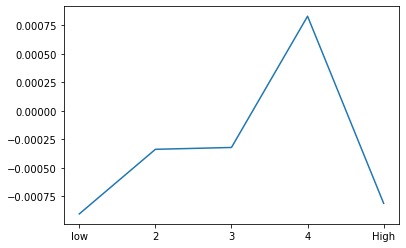

In [204]:
col = 'ratio_fin'
q = df_out.quantile([0.00, 0.2, 0.40, 0.6,0.8, 1.00])

q1 = ((df_out[col]>=q[col][0.00]) & (df_out[col]<q[col][0.20]))
q2 = ((df_out[col]>=q[col][0.20]) & (df_out[col]<q[col][0.40]))
q3 = ((df_out[col]>=q[col][0.40]) & (df_out[col]<q[col][0.60]))
q4 = ((df_out[col]>=q[col][0.60]) & (df_out[col]<q[col][0.80]))
q5 = ((df_out[col]>=q[col][0.80]) & (df_out[col]<=q[col][1.00]))

Quintile = ['low', '2', '3', '4','High']

Median_Return = [df_out[['return']][q1].median()[0], df_out[['return']][q2].median()[0], \
       df_out[['return']][q3].median()[0], df_out[['return']][q4].median()[0],df_out[['return']][q5].median()[0]]
  
plt.plot(Quintile,Median_Return)

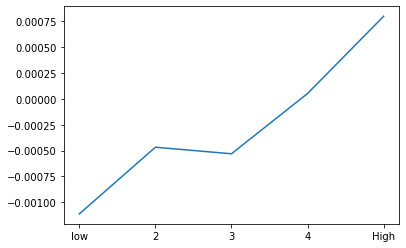

In [205]:
col = 'tfidf_h4'
q = df_out.quantile([0.00, 0.2, 0.40, 0.6,0.8, 1.00])

q1 = ((df_out[col]>=q[col][0.00]) & (df_out[col]<q[col][0.20]))
q2 = ((df_out[col]>=q[col][0.20]) & (df_out[col]<q[col][0.40]))
q3 = ((df_out[col]>=q[col][0.40]) & (df_out[col]<q[col][0.60]))
q4 = ((df_out[col]>=q[col][0.60]) & (df_out[col]<q[col][0.80]))
q5 = ((df_out[col]>=q[col][0.80]) & (df_out[col]<=q[col][1.00]))

Quintile = ['low', '2', '3', '4','High']

Median_Return = [df_out[['return']][q1].median()[0], df_out[['return']][q2].median()[0], \
       df_out[['return']][q3].median()[0], df_out[['return']][q4].median()[0],df_out[['return']][q5].median()[0]]
  
plt.plot(Quintile,Median_Return)

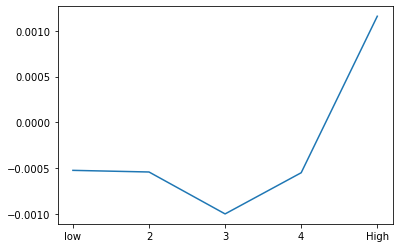

In [206]:
col = 'tfidf_neg'
q = df_out.quantile([0.00, 0.2, 0.40, 0.6,0.8, 1.00])

q1 = ((df_out[col]>=q[col][0.00]) & (df_out[col]<q[col][0.20]))
q2 = ((df_out[col]>=q[col][0.20]) & (df_out[col]<q[col][0.40]))
q3 = ((df_out[col]>=q[col][0.40]) & (df_out[col]<q[col][0.60]))
q4 = ((df_out[col]>=q[col][0.60]) & (df_out[col]<q[col][0.80]))
q5 = ((df_out[col]>=q[col][0.80]) & (df_out[col]<=q[col][1.00]))

Quintile = ['low', '2', '3', '4','High']

Median_Return = [df_out[['return']][q1].median()[0], df_out[['return']][q2].median()[0], \
       df_out[['return']][q3].median()[0], df_out[['return']][q4].median()[0],df_out[['return']][q5].median()[0]]
  
plt.plot(Quintile,Median_Return)

In [221]:
df_out = df[['ticker','date','3_day_buy_and_hold_excess_return','3_day_buy_and_hold_excess_log_return','ratio_h4',\
            'ratio_fin','tfidf_h4','tfidf_neg']]


In [223]:
df_out.to_csv('final_result.csv')